- Update log
  - 6.12
    - 增加了通过均值方差生成theta的theta_gen，但发现很难精准控制值
      - 预计仍旧采用随机采样分析  
      - 可以考虑在特定区间，如theta in  [0.01,0.1]，进行分析
    - TS算法完工
    - 可视化
      - 统计了对于无明显特征的theta组，采用1000量级的先验参数误差较小（效果最好）的次数最多
    -  可能的目标
       -  直接将1000量级的实验结果取出，和另外两个算法的最优比较（只比较均值，所以是柱状图；只比较排名第一次数，所以也是柱状图）
       -  将theta的区间从[0,1]转换为[0.001,0.1]，再度进行一个完整流程的探索
  - 6.13 
    - 根据数学求解，完成拥有特征：均值、标准差 、theta1的thetaSeq
    - 确定了最终的Theta选择参数

## Theta Generate & ThetaSequence Definition

In [3]:
## specific_theta_geneta
import numpy as np
import matplotlib.pyplot as plt

class ThetaSequence:
    def __init__(self, seq: np.ndarray, n_elements: int):
        self.seq = seq
        self.n_elem = n_elements
        self.mean = np.mean(seq)
        self.var = np.var(seq)
        self.max_theta = np.max(seq)
        self.std_dev = np.std(seq)

## randomly generate
def generate_theta_sequence_set(n_elem, n_sets):
    theta_seq_set = []
    for _ in range(n_sets):
        theta_seq = ThetaSequence(np.random.uniform(0, 1, size=n_elem), n_elem)
        theta_seq_set.append(theta_seq)
    return np.array(theta_seq_set)

## 用theta组的数值特征，判断不同参数对不同特征的适应性
## 每个theta 跑200次，每次5000下摇杆

## 数值大小随意，数值特征重要
# 均值0.05为跨度，标准差1/20为跨度

## 6.12更新
# ## 使用固定的均值、标准差，生成n和数据（theta_seq）

## 6.13更新
## 由数学关系得到具有特征 theta1，均值，标准差的thetaSeq
## 不需要输入数字，因为只能生成三个
def specific_theta_generate(mean, std_dev, theta1=np.random.uniform(0, 1)):
    coff_a = 2
    coff_b = 2 * theta1 - 6 * mean
    coff_c = 6 * (mean ** 2) - 3 * (std_dev ** 2) + (2 * theta1 ** 2) - 6 * mean * theta1
    count = 0
    while count < 1000:
        count += 1
        delta = coff_b ** 2 - 4 * coff_a * coff_c
        # print("delta problem")
        if delta >= 0:
            theta2 = (-coff_b + np.sqrt(delta)) / (2 * coff_a)
            theta3 = (-coff_b - np.sqrt(delta)) / (2 * coff_a)
            if 0 <= theta2 <= 1 and 0 <= theta3 <= 1:
                # print([theta1, theta2, theta3])
                return ThetaSequence(np.array([theta1, theta2, theta3]),3)
            # print("0,1 problem: {}".format([theta1, theta2, theta3]))
            
        theta1 = np.random.uniform(0, 1)
        coff_b = 2 * theta1 - 6 * mean
        coff_c = 6 * (mean ** 2) - 3 * (std_dev ** 2) + (2 * theta1 ** 2) - 6 * mean * theta1
    else:
    # 如果无法找到合法的 theta1、theta2 和 theta3，则返回 None
        # print("Mean: {}, Std_Dev: {}".format(mean, std_dev))
        return None
    # theta 中更小的那个的表达式：(-coff_b - np.sqrt(coff_b**2 - 4 * coff_a * coff_c))/(2*coff_a)

## 静均值，动标准差
def theta_generate_static_mean_rolling_std_dev(mean, start_std_dev, end_std_dev, span):
    theta_set = []
    for rolling_std_dev in np.arange(start_std_dev, end_std_dev, span):
        theta_group = specific_theta_generate(mean, rolling_std_dev)
        if not theta_group == None:
            theta_set.append(theta_group)
    return np.array(theta_set)

## 静标准差，动均值
def theta_generate_static_std_dev_rolling_mean(std_dev, start_mean, end_mean, span):
    theta_set = []
    for rolling_mean in np.arange(start_mean, end_mean, span):
        theta_group = specific_theta_generate(rolling_mean, std_dev)
        if not theta_group == None:
            theta_set.append(theta_group)
    return np.array(theta_set)



Mean: 0.25, Std_Dev: 0.3960008417499471
Mean: 0.85, Std_Dev: 0.30618621784789724

In [4]:
## Specific Generate
## mean [0,1,0.001]
## std_dev [0, np.sqrt(1/6), np.sqrt(1/6)/1000]

min_mean = 0
max_mean = 1
min_std_dev = 0
max_std_dev = np.sqrt(1/6)

# print(np.arange(max_std_dev/100, max_std_dev, max_std_dev/100))

static_mean_rolling_std_dev_set = []
for static_mean in np.arange(max_mean/4, max_mean-0.01, max_mean/4):
  static_mean_rolling_std_dev_set.append(theta_generate_static_mean_rolling_std_dev(static_mean, max_std_dev/100, max_std_dev, max_std_dev/100))


static_std_dev_rolling_mean_set = []
for static_std_dev in np.arange(np.sqrt(1/6)/4, np.sqrt(1/6) - 0.00001, np.sqrt(1/6)/4):
  static_std_dev_rolling_mean_set.append(theta_generate_static_std_dev_rolling_mean(static_std_dev, max_mean/100, max_mean, max_mean/100))


print(len(static_mean_rolling_std_dev_set[0]))
print(len(static_mean_rolling_std_dev_set[1]))
print(len(static_mean_rolling_std_dev_set[2]))

print(len(static_std_dev_rolling_mean_set[0]))
print(len(static_std_dev_rolling_mean_set[1]))
print(len(static_std_dev_rolling_mean_set[2]))

86
99
86
85
71
57


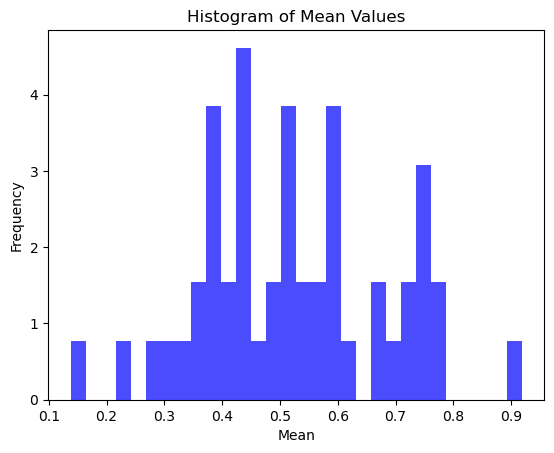

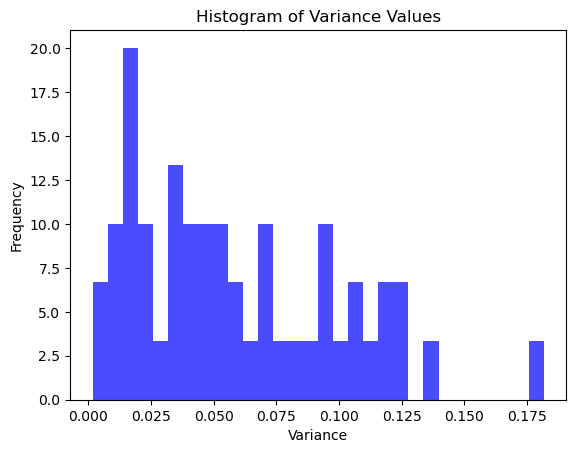

In [5]:
## Gen Field 随机
n_elem = 3
n_sets = 50

theta_seq_set = generate_theta_sequence_set(n_elem, n_sets)

# 提取 ThetaSequence 对象的 mean 属性作为数据序列
mean_values = [theta_seq.mean for theta_seq in theta_seq_set]
plt.hist(mean_values, bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Values')
plt.show()

# 提取 ThetaSequence 对象的 variance 属性作为数据序列
variance_values = [theta_seq.var for theta_seq in theta_seq_set]
plt.hist(variance_values, bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Variance Values')
plt.show()

## Beta Prio Gen

In [6]:
def beta_prio_generate(theta_seq_set: np.ndarray, min_n_trails: int):
  para_set_min = [[],[],[]]
  for theta_seq in theta_seq_set:
    ## 以下针对一组thetaSeq
    for k in range(3):
      para = []
      for theta in theta_seq.seq:
        res = np.random.binomial(1, theta, (10 ** k)*min_n_trails)
        ## +1 保证参数不为零
        para.append([np.sum(res)+1, (10 ** k)*min_n_trails - np.sum(res)+1])
      para_set_min[k].append(para)
  return para_set_min
## 性能优化：所有数组先申请好成1，最后再增加
para_exp = beta_prio_generate(theta_seq_set, min_n_trails=10)

## 针对性的一次TS

I'm calculating, plz wait.
4899.6 4211.2 4929.0 4888.2
   delta: -688.4 29.4 -11.4
Theta-Var: 0.0321   best-arm: 3

4190.3 3739.6 4170.0 4288.6
   delta: -450.7 -20.3 98.3
Theta-Var: 0.0562   best-arm: 2

3171.8 3339.4 3155.4 3265.2
    delta: 167.6 -16.4 93.4
Theta-Var: 0.0768   best-arm: 2

3967.3 4393.6 3383.2 3943.8
  delta: 426.3 -584.1 -23.5
Theta-Var: 0.0253   best-arm: 3

3609.8 3773.4 3633.2 3423.2
   delta: 163.6 23.4 -186.6
Theta-Var: 0.0971   best-arm: 2

1049.4 1774.0 1250.0 1037.8
   delta: 724.6 200.6 -11.6
Theta-Var: 0.0058   best-arm: 3

4727.0 4586.4 4447.8 4734.8
   delta: -140.6 -279.2 7.8
Theta-Var: 0.0346   best-arm: 3

4435.1 4935.0 4756.0 4486.6
    delta: 499.9 320.9 51.5
Theta-Var: 0.0142   best-arm: 3

4703.5 3904.8 4524.4 4673.2
 delta: -798.7 -179.1 -30.3
Theta-Var: 0.1015   best-arm: 3

4904.4 4111.6 4714.0 4880.2
 delta: -792.8 -190.4 -24.2
Theta-Var: 0.1213   best-arm: 3

4350.3 4215.2 4195.4 4345.8
  delta: -135.1 -154.9 -4.5
Theta-Var: 0.0107   best-ar

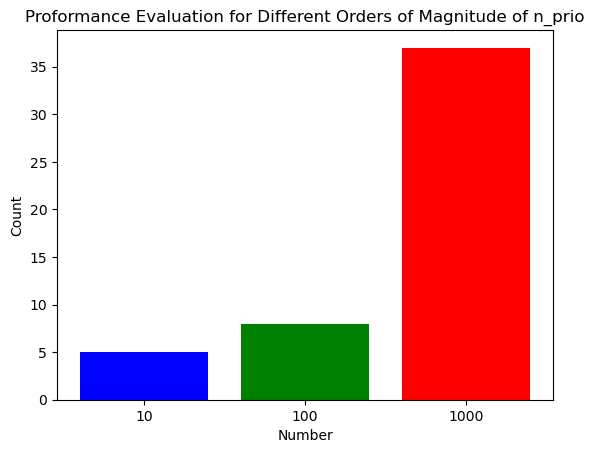

In [7]:
## 参数修正后的TS

## 问题是没有得到最终的策略
def Thompson_Sampling_once(n_arms, n_trials, beta_prio):
  sampled_theta = np.zeros(n_arms)
  reward = np.zeros(n_arms, dtype=int)
  for _ in range(n_trials):
    for i in range(n_arms):
      sampled_theta[i] = np.random.beta(beta_prio[i][0],beta_prio[i][1])
    max_arm = np.argmax(sampled_theta)
    cor_reward = np.random.binomial(1, sampled_theta[max_arm])
    beta_prio[max_arm][0] += cor_reward
    beta_prio[max_arm][1] +=  (1 - cor_reward) 
    reward[max_arm] += cor_reward

  for i in range(n_arms):
    ## final update
    sampled_theta[i] = np.random.beta(beta_prio[i][0],beta_prio[i][1])  
  # print(np.sum(reward))
  return np.sum(reward)



final_reward_para_exp_0 = []
final_reward_para_exp_1 = []
final_reward_para_exp_2 = []



print("I'm calculating, plz wait.")
for i in range(len(theta_seq_set)):
  ## 对第i组theta做500次实验，取平均
  reward_0, reward_1, reward_2 = [], [], []

  ## 5次实验，5000 time slots，否则真有点久
  for j in range(5):
    reward_0.append(Thompson_Sampling_once(3, 5000, para_exp_0[i]))
    reward_1.append(Thompson_Sampling_once(3, 5000, para_exp_1[i]))
    reward_2.append(Thompson_Sampling_once(3, 5000, para_exp_2[i]))
  final_reward_para_exp_0.append(np.mean(np.array(reward_0)))
  final_reward_para_exp_1.append(np.mean(np.array(reward_1)))
  final_reward_para_exp_2.append(np.mean(np.array(reward_2)))


# for i in range(len(theta_seq_set)):
#   print(str(theta_seq_set[i].max_theta * 5000)+" "+str(final_reward_para_exp_0[i])+" "+str(final_reward_para_exp_1[i])+" "+str(final_reward_para_exp_2[i]))
#   print("delta:" + str(final_reward_para_exp_0[i]-theta_seq_set[i].max_theta * 5000) + str(final_reward_para_exp_0[i]-theta_seq_set[i].max_theta * 5000) + str(final_reward_para_exp_0[i]-theta_seq_set[i].max_theta * 5000))


# print(final_reward_para_exp_0)
# print(final_reward_para_exp_1)
# print(final_reward_para_exp_2)
magnitude_performance_static=[]
for i in range(len(theta_seq_set)):
    # 获取格式化的原数值字符串
    values_str = "{:.1f} {:.1f} {:.1f} {:.1f}".format(
        theta_seq_set[i].max_theta * 5000,
        final_reward_para_exp_0[i],
        final_reward_para_exp_1[i],
        final_reward_para_exp_2[i]
    )
    
    # 计算各delta值
    delta_0 = final_reward_para_exp_0[i] - theta_seq_set[i].max_theta * 5000
    delta_1 = final_reward_para_exp_1[i] - theta_seq_set[i].max_theta * 5000
    delta_2 = final_reward_para_exp_2[i] - theta_seq_set[i].max_theta * 5000
    
    # 获取格式化的delta字符串
    delta_str = "delta: {:.1f} {:.1f} {:.1f}".format(delta_0, delta_1, delta_2)
    delta = [abs(delta_0),abs(delta_1),abs(delta_2)]
    # 打印原数值和delta，保证delta字符串右对齐
    print(values_str)
    print(delta_str.rjust(len(values_str)))
    print("Theta-Var: {:.4f}   best-arm: {:1}".format(theta_seq_set[i].var, 1+np.argmin([delta])))
    magnitude_performance_static.append(1+np.argmin([delta]))
    print()
    ## 统计个数？

# 统计1，2，3的个数
count_10 = magnitude_performance_static.count(1)
count_100 = magnitude_performance_static.count(2)
count_1000 = magnitude_performance_static.count(3)

# 打印统计结果
print(f"Count of 1: {count_10}")
print(f"Count of 2: {count_100}")
print(f"Count of 3: {count_1000}")

# 准备绘图数据
labels = ['10', '100', '1000']
counts = [count_10, count_100, count_1000]

# 绘制条形图
plt.bar(labels, counts, color=['blue', 'green', 'red'])

# 设置标题和标签
plt.xlabel('Number')
plt.ylabel('Count')
plt.title('Proformance Evaluation for Different Orders of Magnitude of n_prio') #先验个数数量级（10，100，1000）

# 显示图表
plt.show()


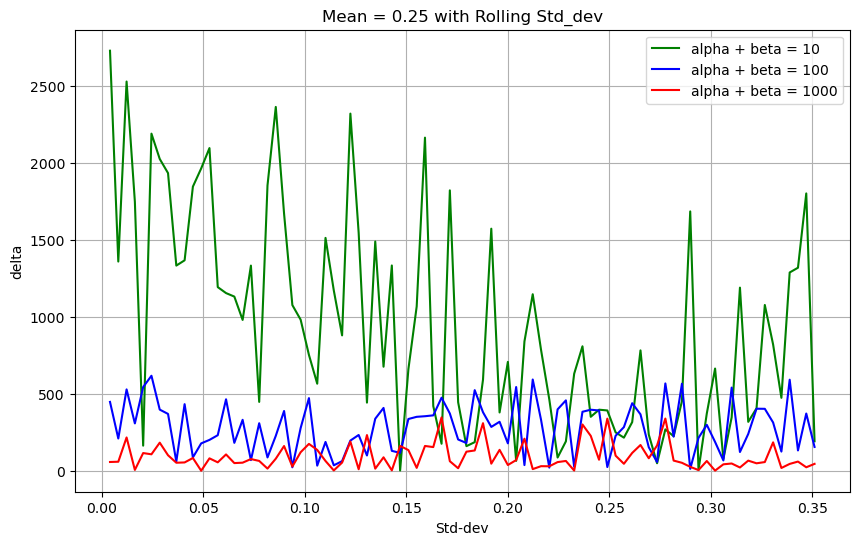

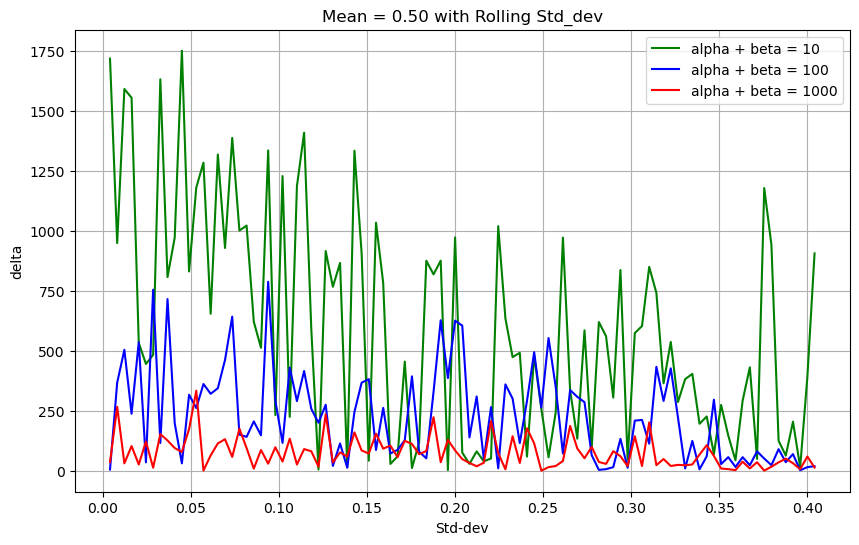

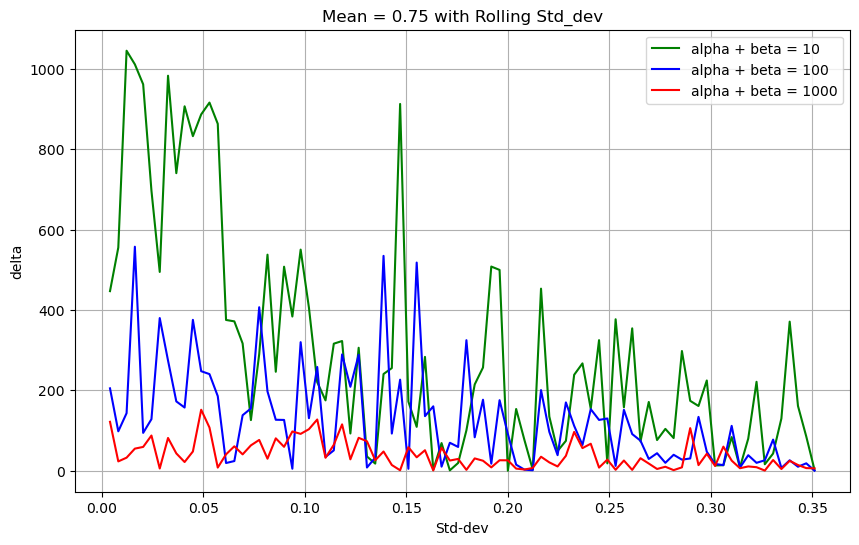

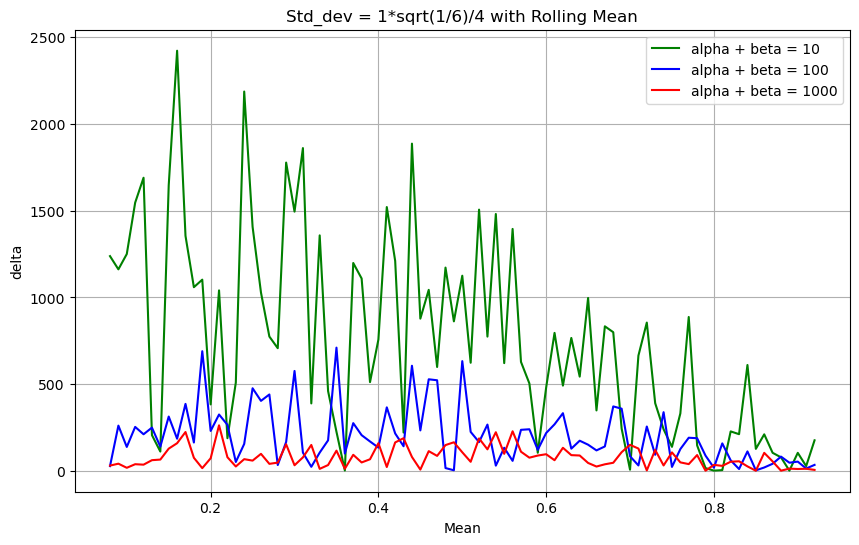

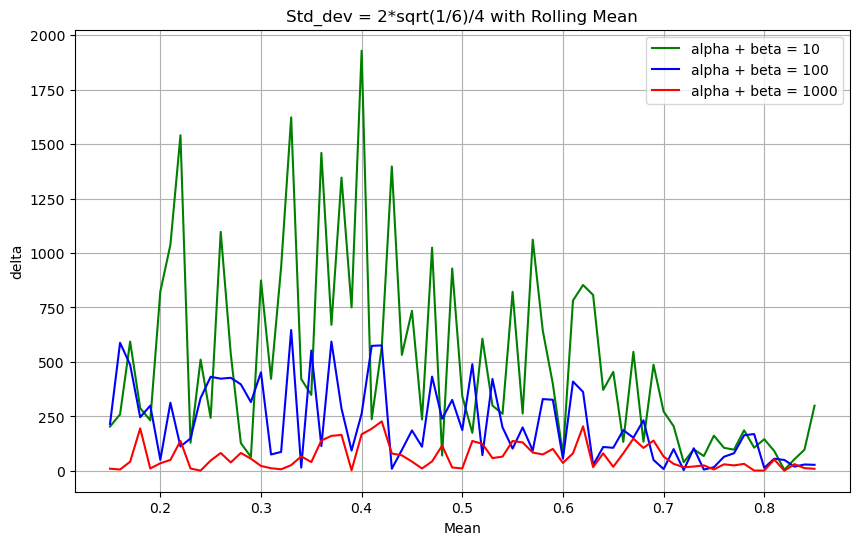

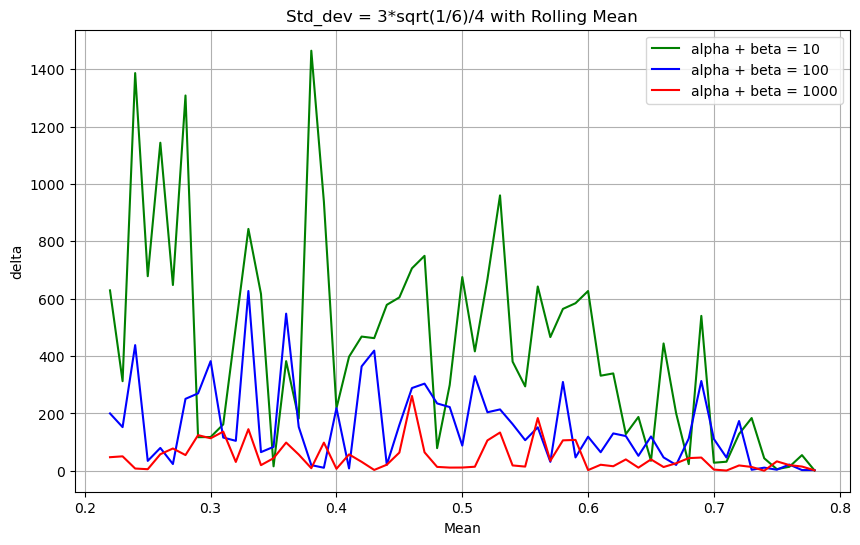

In [8]:
## relationship between parameter, mean, std_dev

# mean: 0.25, std_dev: [0, sqrt(1/6)]   static_mean_rolling_std_dev_set[0]
# mean: 0.25, std_dev: [0, sqrt(1/6)]   static_mean_rolling_std_dev_set[1]
# mean: 0.25, std_dev: [0, sqrt(1/6)]   static_mean_rolling_std_dev_set[2]


# std_dev: sqrt(1/6)/4 * 1, rolling mean  static_std_dev_rolling_mean_set[0]
# std_dev: sqrt(1/6)/4 * 2, rolling mean  static_std_dev_rolling_mean_set[1]
# std_dev: sqrt(1/6)/4 * 3, rolling mean  static_std_dev_rolling_mean_set[2]


def packaged_Thompson_Sampling(theta_set, n_arms, n_experiments, n_slots, para):
  final_reward_para_exp = [[], [], []]
  for i in range(len(theta_set)):
    ## 对第i组theta做n_experiments次实验，取平均
    reward = [[], [], []]

    for _ in range(n_experiments):
      for j in range(len(para)):
        reward[j].append(Thompson_Sampling_once(n_arms, n_slots, para[j][i]))

    for k in range(len(para)):
      final_reward_para_exp[k].append(np.mean(np.array(reward[k])))

  delta = [[], [], []]
  mean, std_dev = [], []
  for i in range(len(theta_set)):
    for j in range(len(delta)):
      delta[j].append(abs(final_reward_para_exp_0[i] - theta_set[i].max_theta * n_slots))
    mean.append(theta_set[i].mean)
    std_dev.append(theta_set[i].std_dev)
  return delta, mean, std_dev

def plot_n_lines(n_line, x, y_axis, title, x_label, y_labels, colors):
  fig, ax = plt.subplots(figsize=(10, 6))
  
  for i in range(n_line):
    ax.plot(x, y_axis[i], color=colors[i], label=y_labels[i])
  
  ax.set_title(title)
  ax.set_xlabel(x_label)
  ax.set_ylabel('delta')
  
  ax.legend()
  
  plt.grid(True)
  plt.show()
    
  return

n_experi = 10
n_slot = 5000
n_arms = 3
labels = ['alpha + beta = 10','alpha + beta = 100','alpha + beta = 1000']
n_line = 3
line_color = ['green','blue','red']

para_exp = beta_prio_generate(static_mean_rolling_std_dev_set[0], min_n_trails=10)
y_delta, x_mean, x_std_dev = packaged_Thompson_Sampling(static_mean_rolling_std_dev_set[0], n_arms, n_experi, n_slot, para_exp)
plot_n_lines(n_line, x_std_dev, y_delta, 'Mean = 0.25 with Rolling Std_dev' ,'std-dev' , labels, line_color)

para_exp = beta_prio_generate(static_mean_rolling_std_dev_set[1], min_n_trails=10)
y_delta, x_mean, x_std_dev = packaged_Thompson_Sampling(static_mean_rolling_std_dev_set[1], n_arms, n_experi, n_slot, para_exp)
plot_n_lines(n_line, x_std_dev, y_delta, 'Mean = 0.50 with Rolling Std_dev', 'std-dev' , labels, line_color)

para_exp = beta_prio_generate(static_mean_rolling_std_dev_set[2], min_n_trails=10)
y_delta, x_mean, x_std_dev = packaged_Thompson_Sampling(static_mean_rolling_std_dev_set[2], n_arms, n_experi, n_slot, para_exp)
plot_n_lines(n_line, x_std_dev, y_delta, 'Mean = 0.75 with Rolling Std_dev', 'std-dev' , labels, line_color)

para_exp = beta_prio_generate(static_std_dev_rolling_mean_set[0], min_n_trails=10)
y_delta, x_mean, x_std_dev = packaged_Thompson_Sampling(static_std_dev_rolling_mean_set[0], n_arms, n_experi, n_slot, para_exp)
plot_n_lines(n_line, x_mean, y_delta, 'Std_dev = 1*sqrt(1/6)/4 with Rolling Mean', 'mean' , labels, line_color)

para_exp = beta_prio_generate(static_std_dev_rolling_mean_set[1], min_n_trails=10)
y_delta, x_mean, x_std_dev = packaged_Thompson_Sampling(static_std_dev_rolling_mean_set[1], n_arms, n_experi, n_slot, para_exp)
plot_n_lines(n_line, x_mean, y_delta, 'Std_dev = 2*sqrt(1/6)/4 with Rolling Mean', 'mean' , labels, line_color)

para_exp = beta_prio_generate(static_std_dev_rolling_mean_set[2], min_n_trails=10)
y_delta, x_mean, x_std_dev = packaged_Thompson_Sampling(static_std_dev_rolling_mean_set[2], n_arms, n_experi, n_slot, para_exp)
plot_n_lines(n_line, x_mean, y_delta, 'Std_dev = 3*sqrt(1/6)/4 with Rolling Mean', 'mean' , labels, line_color)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.stats import beta
import scipy.stats as sci

def plot_beta_distribution(alpha, beta):
    """
    绘制 Beta 分布曲线
    
    参数:
    alpha (float): Beta 分布的第一个参数
    beta (float): Beta 分布的第二个参数
    """
    # 生成 x 轴数据
    x = np.linspace(0, 1, 100)
    
    # 计算 Beta 分布概率密度函数
    y = sci.beta.pdf(x, alpha, beta)
    
    # 绘制图像
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(x, y, color='blue', linewidth=2)
    ax.set_title(f'Beta Distribution (α={alpha:.2f}, β={beta:.2f})')
    ax.set_xlabel('x')
    ax.set_ylabel('Probability Density')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, max(y) * 1.1)
    plt.show()

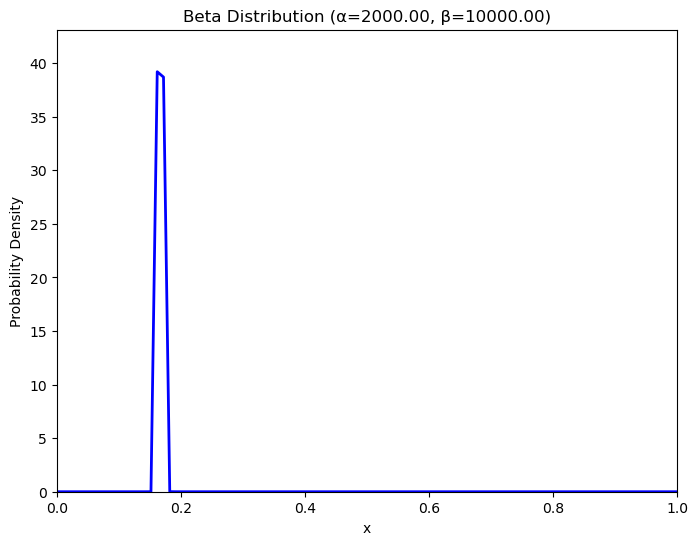

In [13]:
plot_beta_distribution(2000, 10000)

In [11]:
print(np.random.beta(10,90,10))


[0.08707026 0.08739486 0.1031882  0.13474095 0.0846544  0.08875141
 0.0906411  0.142246   0.17396298 0.11357413]


In [12]:
def plot_n_lines(n_line, x, y_axis, title, x_label, y_labels, colors):
  fig, ax = plt.subplots(figsize=(10, 6))
  
  for i in range(n_line):
    ax.plot(x, y_axis[i], color=colors[i], label=y_labels[i])
  
  ax.set_title(title)
  ax.set_xlabel(x_label)
  ax.set_ylabel('delta')
  
  ax.legend()
  
  plt.grid(True)
  plt.show()
    
  return

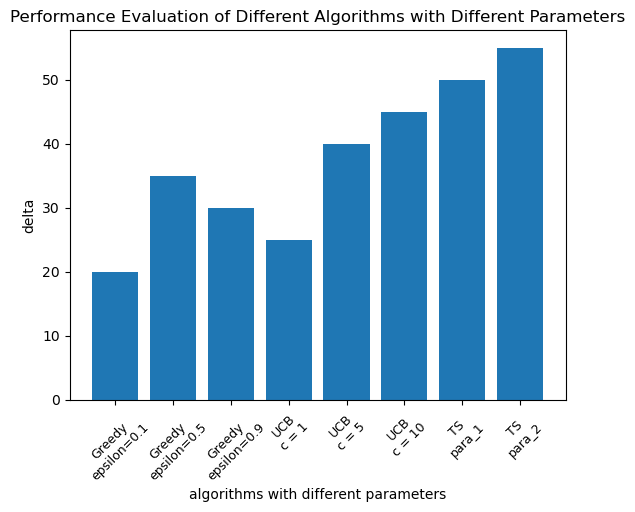

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
x = np.arange(8)
y = [20, 35, 30, 25, 40, 45, 50, 55]


def plot_bar_chart(x_axis, y_axis, title, x_labels, y_label = 'delta'):
  plt.bar(x_axis,y_axis)

  plt.xticks(x_axis, x_labels,rotation=45, fontsize=9)
  plt.xlabel('algorithms with different parameters')
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()

x_labels = ['Greedy\nepsilon=0.1', 'Greedy\nepsilon=0.5', 'Greedy\nepsilon=0.9', 'UCB\nc = 1', 'UCB\nc = 5', 'UCB\nc = 10', 'TS\npara_1', 'TS\npara_2']
plot_bar_chart(x,y,'Performance Evaluation of Different Algorithms with Different Parameters',x_labels=x_labels)